# Erebus Stacked Timeseries Plot

In [2]:
import scipy
import pandas as pd
import obspy
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('pdf', fonttype=42)

plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")

## Load explosion times, get 10 largest that occur when horizontal component data is available

In [5]:
# Load explosion times from Chaput (Knox?) catalog
data0 = scipy.io.loadmat("./data/Eruptions_max_times.mat")
data1 = scipy.io.loadmat("./data/eruption_times_fix.mat")

del data0["__header__"]
del data0["__version__"]
del data0["__globals__"]

del data1["__header__"]
del data1["__version__"]
del data1["__globals__"]

# Undo some weird structure from mat file reading
data1["eruption_time"] = [str(time[0]) for time in data1["eruption_time"][0]]
data0["mx"] = data0["mx"][0]

data = {"eruption_time": data1["eruption_time"], "mx": data0["mx"]}

df = pd.DataFrame(data)

# Convert times to datetime objects
df["eruption_time"] = pd.to_datetime(df["eruption_time"], format="%Y/%m/%d  %H:%M:%S")

# Window out events outside 2003-2013
df = df[df["eruption_time"] > "2003-01-01"]
df = df[df["eruption_time"] < "2013-01-01"]

# Sort by size
df = df.sort_values("mx", ascending=False)

In [6]:
def get_avail(network, station, channel, start, stop):
    # Make URL
    url = "http://service.iris.edu/fdsnws/availability/1/query?"
    url += "network=%s&" % network 
    url += "station=%s&" % station 
    url += "channel=%s&" % channel
    url += "start=%s&" % str(start)
    url += "end=%s" % str(stop)
    
    # Send request
    try:
        res = requests.get(url)
    except Exception as e:
        print(e)
        return None
    # Parse result into dataframe
    cols = ["network", "station", "location", "channel", "quality", "samplerate", "earliest", "latest"]
    df = pd.read_csv(io.StringIO(res.text), sep=" ", comment="#", header=None, names=cols)
    df["earliest"] = df["earliest"].apply(obspy.UTCDateTime)
    df["latest"] = df["latest"].apply(obspy.UTCDateTime)
    
    return df

In [7]:
# Get data availability
start = obspy.UTCDateTime("2003-01-01")
stop = obspy.UTCDateTime("2013-01-01") 
avail = get_avail("ER", "NKB,E1S", "BH1,BH2,BHE,BHN", start, stop)

In [8]:
# Get ten largest events with horizontal data available
count = 0
times = []
tbound = 60*40 # 40 minute bound
nevent = 20
# Go until nevent events with 4 channels available
for i, row in df.iterrows():
    t = obspy.UTCDateTime(row["eruption_time"])
    t0 = t - tbound # hour before
    t1 = t + tbound # hour after
    ncha = np.sum(np.logical_and(avail["earliest"] < t0, avail["latest"] > t1))
    if(ncha == 4):
        print(t)
        times.append(t)
        count += 1
    if(count == nevent):
        break

2007-02-11T05:12:35.000000Z
2007-02-07T02:54:19.000000Z
2007-02-04T05:49:28.000000Z
2007-02-16T08:34:49.000000Z
2007-02-03T09:43:34.000000Z
2007-02-14T05:12:42.000000Z
2007-02-15T01:47:29.000000Z
2007-01-25T05:04:32.000000Z
2007-02-11T11:36:07.000000Z
2007-02-09T11:22:08.000000Z
2007-02-04T02:40:48.000000Z
2007-02-22T09:05:55.000000Z
2007-02-06T10:21:31.000000Z
2007-02-01T12:33:34.000000Z
2007-02-21T03:54:20.000000Z
2007-02-14T08:09:28.000000Z
2006-01-17T01:21:31.000000Z
2007-01-30T08:55:51.000000Z
2007-01-31T09:06:00.000000Z
2007-02-10T11:32:44.000000Z


In [11]:
# Write out file for pysep
with open("./data/erebus_events.txt", mode="w") as fd:
    # skip second one because of data gap (pysep download fails)
    for t in times:
        fd.write("%s 167.1523 -77.5293 0 0\n" % str(t))

In [12]:
# Load times
with open("./data/erebus_events.txt", mode="r") as fd:
    for line in fd:
        print(line)

2007-02-11T05:12:35.000000Z 167.1523 -77.5293 0 0

2007-02-07T02:54:19.000000Z 167.1523 -77.5293 0 0

2007-02-04T05:49:28.000000Z 167.1523 -77.5293 0 0

2007-02-16T08:34:49.000000Z 167.1523 -77.5293 0 0

2007-02-03T09:43:34.000000Z 167.1523 -77.5293 0 0

2007-02-14T05:12:42.000000Z 167.1523 -77.5293 0 0

2007-02-15T01:47:29.000000Z 167.1523 -77.5293 0 0

2007-01-25T05:04:32.000000Z 167.1523 -77.5293 0 0

2007-02-11T11:36:07.000000Z 167.1523 -77.5293 0 0

2007-02-09T11:22:08.000000Z 167.1523 -77.5293 0 0

2007-02-04T02:40:48.000000Z 167.1523 -77.5293 0 0

2007-02-22T09:05:55.000000Z 167.1523 -77.5293 0 0

2007-02-06T10:21:31.000000Z 167.1523 -77.5293 0 0

2007-02-01T12:33:34.000000Z 167.1523 -77.5293 0 0

2007-02-21T03:54:20.000000Z 167.1523 -77.5293 0 0

2007-02-14T08:09:28.000000Z 167.1523 -77.5293 0 0

2006-01-17T01:21:31.000000Z 167.1523 -77.5293 0 0

2007-01-30T08:55:51.000000Z 167.1523 -77.5293 0 0

2007-01-31T09:06:00.000000Z 167.1523 -77.5293 0 0

2007-02-10T11:32:44.000000Z 167

## Grab data with pysep and estimate tilt

In [15]:
!pysep -o -c ./data/erebus_pysep.yaml -E ./data/erebus_events.txt
!mv *VICTORIA* data/seis

[2024-08-12 14:34:36] - pysep - INFO: looping over 20 events for event file run
[2024-08-12 14:34:36] - pysep - DEBUG: running PySEP version 0.6.1
[2024-08-12 14:34:36] - pysep - INFO: will NOT overwrite event search parameters (including origin and reference time) with config file
[2024-08-12 14:34:36] - pysep - INFO: overwriting default parameters with config file: './data/erebus_pysep.yaml'
[2024-08-12 14:34:36] - pysep - DEBUG: event_tag: None -> Erebus
[2024-08-12 14:34:36] - pysep - DEBUG: seconds_before_ref: 100 -> 2400
[2024-08-12 14:34:36] - pysep - DEBUG: seconds_after_ref: 300 -> 2400
[2024-08-12 14:34:36] - pysep - DEBUG: networks: * -> ER
[2024-08-12 14:34:36] - pysep - DEBUG: stations: * -> NKB,E1S
[2024-08-12 14:34:36] - pysep - DEBUG: channels: * -> BH?
[2024-08-12 14:34:36] - pysep - DEBUG: demean: True -> False
[2024-08-12 14:34:36] - pysep - DEBUG: detrend: True -> False
[2024-08-12 14:34:36] - pysep - DEBUG: remove_response: True -> False
[2024-08-12 14:34:36] - pys

In [18]:
!seinei -v -a -f 2 -pbl 3600 -pbs 60 ./data/seis/2007-01-25T050432_VICTORIA_LAND_ANTARCTICA/inv.xml ./data/seis/*VICTORIA*/SAC/20*.sac

Reading inventory file:
	./data/seis/2007-01-25T050432_VICTORIA_LAND_ANTARCTICA/inv.xml
Reading SAC file(s):
	./data/seis/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA/SAC/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA.ER.E1S..BH1.sac
	./data/seis/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA/SAC/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA.ER.E1S..BH2.sac
	./data/seis/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA/SAC/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA.ER.E1S..BHZ.sac
	./data/seis/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA/SAC/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA.ER.NKB..BH1.sac
	./data/seis/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA/SAC/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA.ER.NKB..BH2.sac
	./data/seis/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA/SAC/2006-01-17T012131_VICTORIA_LAND_ANTARCTICA.ER.NKB..BHZ.sac
	./data/seis/2007-01-25T050432_VICTORIA_LAND_ANTARCTICA/SAC/2007-01-25T050432_VICTORIA_LAND_ANTARCTICA.ER.E1S..BH1.sac
	./data/seis/2007-01-25T050432_VICTORIA_LAND_ANTARCTICA/SA

## Load and plot tilt

In [19]:
st = obspy.read("./data/seis/*VICTORIA*/SAC/tilt*.sac")

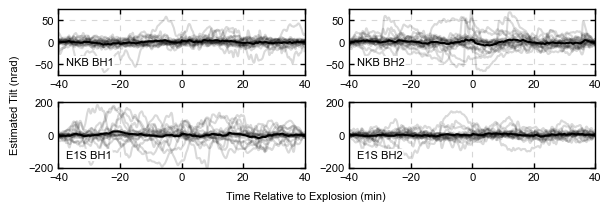

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(6,2), constrained_layout=True)
min_in_day = 60*24
sealpha = .15

# NKB BH1
mrec = np.zeros_like(st.select(station="NKB", channel="BH1").slice(starttime=times[0]-3600, endtime=times[0]+3600)[0].data)
for t in times:
    tr = st.select(station="NKB", channel="BH1").slice(starttime=t-3600, endtime=t+3600)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    mrec += data
    axs[0,0].plot(trel*min_in_day, data*1e9, "k-", alpha=sealpha)
mrec /= len(times)
axs[0,0].plot(trel*min_in_day, mrec*1e9, "k")
axs[0,0].set_ylim(-75, 75)
#axs[0,0].set_title("NKB BH1", fontsize=8)
axs[0,0].annotate(
    "NKB BH1",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# NKB BH2
mrec = np.zeros_like(st.select(station="NKB", channel="BH2").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
for t in times:
    tr = st.select(station="NKB", channel="BH2").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    mrec += data
    axs[0,1].plot(trel*min_in_day, data*1e9, "k-", alpha=sealpha)
mrec /= len(times)
axs[0,1].plot(trel*min_in_day, mrec*1e9, "k")
axs[0,1].set_ylim(-75, 75)
#axs[0,1].set_title("NKB BH2", fontsize=8)
axs[0,1].annotate(
    "NKB BH2",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# E1S BH1
mrec = np.zeros_like(st.select(station="E1S", channel="BH1").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
for t in times:
    tr = st.select(station="E1S", channel="BH1").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    mrec += data
    axs[1,0].plot(trel*min_in_day, data*1e9, "k-", alpha=sealpha)
mrec /= len(times)
axs[1,0].plot(trel*min_in_day, mrec*1e9, "k")
axs[1,0].set_ylim(-200, 200)
#axs[1,0].set_title("E1S BH1", fontsize=8)
axs[1,0].annotate(
    "E1S BH1",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# E1S BH2
mrec = np.zeros_like(st.select(station="E1S", channel="BH2").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
for t in times:
    tr = st.select(station="E1S", channel="BH2").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    mrec += data
    axs[1,1].plot(trel*min_in_day, data*1e9, "k-", alpha=sealpha)
mrec /= len(times)
axs[1,1].plot(trel*min_in_day, mrec*1e9, "k")
axs[1,1].set_ylim(-200, 200)
#axs[1,1].set_title("E1S BH2", fontsize=8)
axs[1,1].annotate(
    "E1S BH2",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

#for ax in axs.flatten():
#    ax.axhline(0.02, color="r", linestyle="--", linewidth=0.5)
#    ax.axhline(-0.02, color="r", linestyle="--", linewidth=0.5)

# Settings for all axes
for ax in axs.flatten():
    ax.set_xlim(-tbound/60, tbound/60)

fig.supxlabel("Time Relative to Explosion (min)", fontsize=8)
fig.supylabel("Estimated Tilt (nrad)", fontsize=8)
fig.savefig("./figs/erebus_timeseries.pdf", bbox_inches="tight")

fig.savefig("./figs/png/erebus_timeseries.png", bbox_inches="tight", dpi=300)